In [1]:
from transformers import AutoProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
def CLIPEncode(image, text):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    #print(outputs)
    return outputs

import torch
def similarity(a,b):
    cosine_similarity = torch.nn.CosineSimilarity() 
    return cosine_similarity(a,b).detach().numpy()


from torchvision import transforms
def l2_dist(a,b):
    transform = transforms.Compose([transforms.PILToTensor()])
    a_tensor = transform(a)
    b_tensor = transform(b)
    a_tensor = a_tensor.reshape(3*32*32)
    b_tensor = b_tensor.reshape(3*32*32)
    dist = torch.nn.PairwiseDistance(p=2)
    return dist(a_tensor,b_tensor)

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
import os
from utils.config import Project_Config
f = Project_Config().folder_symbol

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


######### dataset_type: cifar10
###### model_type: full
Target Image: 


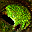

###
VAE_sd1-full_frog_seed_1
Test Image: 


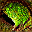

CLIPSim [0.9814411]
l2 dist 9870.822265625
###
DINO_sd1-full_frog_seed_1
Test Image: 


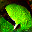

CLIPSim [0.96591026]
l2 dist 7646.35693359375
###### model_type: lora
Target Image: 


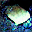

###
DINO_sd1-lora_frog_seed_1
Test Image: 


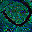

CLIPSim [0.8837453]
l2 dist 8260.609375
###
TRAK_sd1-lora_timestep_1_frog_seed_1
Test Image: 


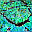

CLIPSim [0.92221445]
l2 dist 8458.56640625
###
DTRAK_sd1-lora_timestep_10_frog_seed_1
Test Image: 


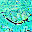

CLIPSim [0.91599196]
l2 dist 7741.38037109375
###
VAE_sd1-lora_frog_seed_1
Test Image: 


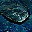

CLIPSim [0.941071]
l2 dist 8606.533203125
###
DTRAK_sd1-lora_timestep_100_frog_seed_1
Test Image: 


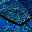

CLIPSim [0.9423083]
l2 dist 8486.59765625
###
TRAK_sd1-lora_timestep_100_frog_seed_1
Test Image: 


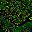

CLIPSim [0.90807796]
l2 dist 8434.619140625
###
DTRAK_sd1-lora_timestep_1_frog_seed_1
Test Image: 


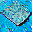

CLIPSim [0.9289272]
l2 dist 7571.70703125
######### dataset_type: cifar2
###### model_type: full
Target Image: 


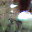

###
DINO_sd1-full_horse_seed_1
Test Image: 


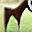

CLIPSim [0.8785744]
l2 dist 8506.1806640625
###### model_type: lora
Target Image: 


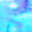

###
DINO_sd1-lora_horse_seed_1
No results yet


In [3]:
from utils.custom_enums import Dataset_Type_Enum, Model_Type_Enum
from PIL import Image
import matplotlib.pyplot as plt

SEED = 1
dataset_results = {}
for dataset_type in Dataset_Type_Enum:
    print(f"######### dataset_type: {dataset_type}")
    if dataset_type == Dataset_Type_Enum.CIFAR10:
        class_caption="frog"
    if dataset_type == Dataset_Type_Enum.CIFAR2:
        class_caption="horse"
    model_type_results = {}
    for model_type in Model_Type_Enum:
        print(f"###### model_type: {model_type}")
        target_image = Image.open(f"datasets/generated-{dataset_type}/sd1-{model_type}/train/{class_caption}/{SEED}.png")
        print("Target Image: ")
        target_image.show()
        images_dict = {}
        images_dict[" Original"] = target_image
        target_image_clip = CLIPEncode(target_image, class_caption)
        base_dir = f"counter_factuals{f}{dataset_type}{f}{model_type}"
        for folder in os.listdir(base_dir):
            print("###")
            print(folder)
            img_path = f"{base_dir}{f}{folder}{f}images{f}{class_caption}_{SEED}.png"
            if os.path.isfile(img_path):
                image_to_test = Image.open(img_path)
                image_to_test_clip = CLIPEncode(image_to_test, class_caption)
                print("Test Image: ")
                image_to_test.show()
                method_name = folder.split("_")[0]
                #Grab the timestep info if we're using DTRAK or TRAK
                if method_name in ["DTRAK", "TRAK"]:
                    method_name = method_name+" "+folder.split("_")[3]+"t"
                images_dict[method_name] = image_to_test
                print(f"CLIPSim {similarity(target_image_clip,image_to_test_clip)}")
                print(f"l2 dist {l2_dist(target_image,image_to_test)}")
            else:
                print("No results yet")
        model_type_results[model_type] = dict(sorted(images_dict.items())).copy()
    dataset_results[dataset_type] = model_type_results.copy()

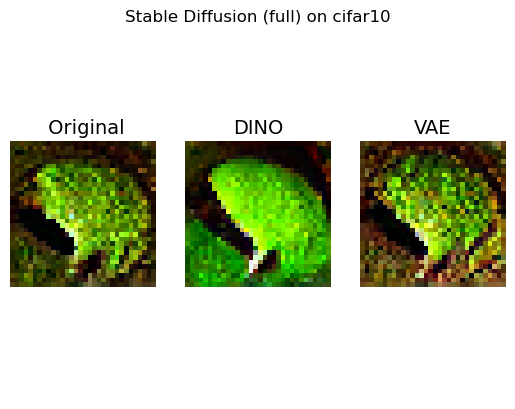

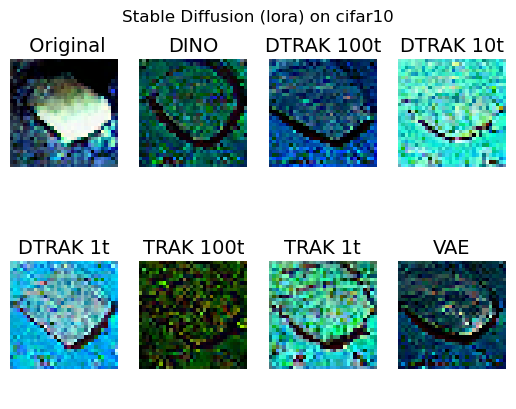

In [6]:
import math
for dataset_name,model_results in dataset_results.items():
    for model_name, method_results in model_results.items():
        i = 0
        plt.title(f"Stable Diffusion ({model_name}) on {dataset_name}")
        plt.axis("off")
        for method_name, image in method_results.items():
            rows = math.ceil(len(method_results)/4)
            columns = len(method_results)//rows
            i = i+1
            plt.subplot(rows,columns,i)
            plt.axis('off')
            if len(method_name) > 10:
                fontsize=10
            else:
                fontsize=14
            plt.title(method_name, fontsize=fontsize)
            plt.imshow(image)
        plt.show()
    #Cifar2 results are incomplete so leave them out
    break